In [1]:
import pandas as pd
from urllib.parse import urlparse
from transformers import BertTokenizer, BertModel
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout


In [2]:
data = pd.read_csv('phishing_site_urls.csv')
data = data.drop_duplicates()

In [3]:
# Remove records with null values
data = data.dropna()


In [4]:

# Label is the column that indicates bad or good URLs
label_counts = data['Label'].value_counts()


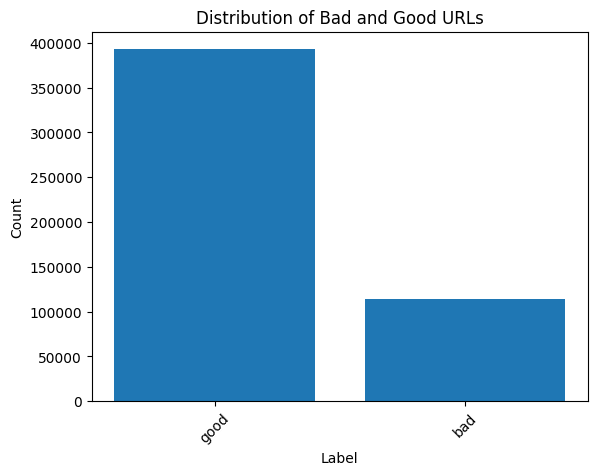

In [5]:
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Bad and Good URLs')
plt.xticks(rotation=45)
plt.show()

In [6]:
# Extract the domain (netloc)
def extract_domain(url):
    parsed_url = urlparse(url)
    return parsed_url.netloc

data['domain'] = data['URL'].apply(extract_domain)

In [7]:
# 'url' is the column containing URLs
urls = data['URL'].tolist()

In [8]:

# Load the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [9]:
# Define the batch size
batch_size = 32  # You can adjust this to your desired batch size
# Initialize a list to store the embeddings
all_embeddings = []

In [10]:
# 'label' is the correct target column
y = data['Label'].tolist()  # 'Label' is the correct column for target labels


In [11]:
# Initialize lists to store all URLs and labels
all_urls = []
all_labels = []


In [12]:

# Iterate over the URLs in smaller batches
for i in range(0, len(urls), batch_size):
    batch_urls = urls[i:i + batch_size]
    batch_labels = y[i:i + batch_size]

    # Handle the case where the last batch may have fewer than batch_size URLs
    if len(batch_urls) < batch_size:
        # Calculate the number of URLs needed to fill the batch
        num_urls_to_fill = batch_size - len(batch_urls)

        # Fill with dummy data or any other approach that makes sense
        batch_urls.extend([''] * num_urls_to_fill)
        batch_labels.extend(['dummy_label'] * num_urls_to_fill)

    # Append the batch_urls and batch_labels to the lists
    all_urls.extend(batch_urls)
    all_labels.extend(batch_labels)


In [13]:
data = None

In [14]:
# Create the final X and y
X = all_urls
y = all_labels

In [15]:
# Tokenize the batch of URLs
tokenized_urls = [tokenizer.encode(url, add_special_tokens=True, truncation=True, max_length=128) for url in X]


In [16]:
# Pad sequences to the same length within the batch
max_length = max(map(len, tokenized_urls))
padded_urls = [url + [0] * (max_length - len(url)) for url in tokenized_urls]


In [17]:
# Convert to PyTorch tensors
input_ids = torch.tensor(padded_urls)


In [ ]:
# Extract BERT embeddings for the batch
with torch.no_grad():
    attention_mask = (input_ids != 0).float()
    embeddings = model(input_ids, attention_mask=attention_mask)[0]


In [ ]:
# Convert embeddings to a NumPy array
X_embeddings = embeddings.numpy()

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_embeddings, y, test_size=0.2, random_state=42)


In [ ]:
# Sequentially implement ensemble learning

In [ ]:

# Random Forest
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train)
rf_predictions = random_forest.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy:.2f}")

In [ ]:

# Support Vector Machine (SVM)
svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train, y_train)
svm_predictions = svm.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)
print(f"SVM Accuracy: {svm_accuracy:.2f}")

In [ ]:

# Assuming rf_predictions and svm_predictions are the predictions from the ensemble models
ensemble_features = np.column_stack((rf_predictions, svm_predictions))

In [ ]:
# Build the CNN model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(ensemble_features.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification output
])

In [ ]:

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:

# Reshape input for CNN (add a channel dimension)
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:

# Train the model
model.fit(X_train_cnn, y_train, epochs=10, batch_size=32, validation_data=(X_test_cnn, y_test))


In [ ]:

# Predict using the trained model
predictions = model.predict(X_test_cnn)
predictions = np.round(predictions).flatten()


In [ ]:

# Accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.2f}")


In [ ]:
# F1-Score
f1 = f1_score(y_test, predictions)
print(f"F1-Score: {f1:.2f}")


In [ ]:

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, predictions)
tn, fp, fn, tp = conf_matrix.ravel()

In [ ]:

# True Positive, True Negative, False Positive, False Negative
print(f"True Positive (TP): {tp}")
print(f"True Negative (TN): {tn}")
print(f"False Positive (FP): {fp}")
print(f"False Negative (FN): {fn}")


In [ ]:

# Precision
precision = precision_score(y_test, predictions)
print(f"Precision: {precision:.2f}")



